In [1]:
# What drives happiness?
# What are the factors that influence suicide rate?

# import dependencies
from config import census_key
import requests
from pprint import pprint
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
# we will want p-values for each variable / beta coefficient
# scikit-learn's LinearRegression doesn't calculate this information but you can easily extend the class to do it
# from https://gist.github.com/brentp/5355925
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [3]:
# Get census data using api
# Variables here:
# https://api.census.gov/data/2017/acs/acs5/variables.html

vars_full = {

    # Education
    'B15001_046E': 'Estimate!!Total!!Female!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_005E': 'Estimate!!Total!!Male!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_044E': 'Estimate!!Total!!Female!!18 to 24 years',
    'B15001_003E': 'Estimate!!Total!!Male!!18 to 24 years',

    # Unemployment
    'B23001_048E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian',
    'B23001_041E': 'Estimate!!Total!!Male!!35 to 44 years!!In labor force!!Civilian',
    'B23001_034E': 'Estimate!!Total!!Male!!30 to 34 years!!In labor force!!Civilian',
    'B23001_050E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian!!Unemployed',
    'B23001_043E': 'Estimate!!Total!!Male!!35 to 44 years!!In labor force!!Civilian!!Unemployed',
    'B23001_036E': 'Estimate!!Total!!Male!!30 to 34 years!!In labor force!!Civilian!!Unemployed',

    # Health Insurance
    'B27001_012E': 'Estimate!!Total!!Male!!26 to 34 years',
    'B27001_015E': 'Estimate!!Total!!Male!!35 to 44 years',
    'B27001_018E': 'Estimate!!Total!!Male!!45 to 54 years',
    'B27001_014E': 'Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage',
    'B27001_017E': 'Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage', 
    'B27001_020E': 'Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage',

    # Poverty
    'B17001_001E': 'Estimate!!Total',
    'B17001_002E': 'Estimate!!Total!!Income in the past 12 months below poverty level',

    # Veteran status
    'B21001_004E': 'Estimate!!Total!!Male',
    'B21001_005E': 'Estimate!!Total!!Male!!Veteran',

    # Disability
    'B18101_013E': 'Estimate!!Total!!Male!!35 to 64 years!!With a disability',
    'B18101_012E': 'Estimate!!Total!!Male!!35 to 64 years',

    # Housing units
    'B25003_003E': 'Estimate!!Total!!Renter occupied',
    'B25003_001E': 'total',

    # Living arrangement
    'B09021_002E': 'Estimate!!Total!!Lives alone',
    'B09021_001E': 'Estimate!!Total',

    # Education
    'B15001_026E': 'Estimate!!Total!!Male!!35 to 44 years!!Graduate or professional degree',
    'B15001_018E': 'Estimate!!Total!!Male!!25 to 34 years!!Graduate or professional degree',
    'B15001_019E': 'Estimate!!Total!!Male!!35 to 44 years',
    'B15001_011E': 'Estimate!!Total!!Male!!25 to 34 years',

    # Population and Race
    'B01003_001E': 'Total population',
    'B02001_004E': 'Estimate!!Total!!American Indian and Alaska Native alone',
    'B02001_006E': 'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone'
}
vars = list(vars_full.keys())

In [4]:
# Variables inspected that showed little or no correlation

#     'B19083_001E': 'GINI INDEX OF INCOME INEQUALITY',
#     # Food Stamps
#     'B22001_004E': 'Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months!!No people in household 60 years or over',
#     'B22001_005E': 'Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months',
#   Travel Time
#     'B08012_013E': 'Estimate!!Total!!90 or more minutes',
#     'B08012_012E': 'Estimate!!Total!!60 to 89 minutes',
#     'B08012_001E': 'Estimate!!Total',
#   Occupation
#     'B24031_005E': 'Estimate!!Total!!Construction',
#     'B24031_001E': 'total',
#   Time leaving for work
#     'B08011_002E': 'Estimate!!Total!!12 00 a.m. to 4 59 a.m.',
#     'B08011_003E': '5-5:30',
#     'B08011_004E': '5:30-6',
#     'B08011_001E': 'Estimate!!Total'
#    Means of transport
#     'B08006_014E': 'Estimate!!Total!!Bicycle',
#     'B08006_001E': 'Estimate!!Total',

In [5]:
url_start = 'https://api.census.gov/data/2017/acs/acs5?get='
url_mid = 'NAME,' + ','.join(vars)
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)

In [6]:
df = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df['state'] + df['county']
county_code = [code.lstrip('0') for code in county_code]
df['County Code'] = county_code
df = df.set_index('County Code')
# # Find Yolo County. Codes here: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
# df.loc[(df['state'] == '06') & (df['county'] == '113')]
# df_full[df_full['NAME'].str.match('Yolo')]

In [64]:
# Import suicide rates csv
path_csv = 'suicide_rates.csv'
df_grim = pd.read_csv(path_csv, converters={'County Code': lambda x: str(x)})
df_grim = df_grim.set_index('County Code')
# Calculate suicide rate per 100k
df_grim['Suicide Rate'] = df_grim['Deaths'] / df_grim['Population'] *100000 

In [8]:
# Import county land area csv
path_csv = 'county_areas.csv'
df_areas = pd.read_csv(path_csv)
df_areas['County Code'] = df_areas['County Code'].astype(str)
df_areas = df_areas.set_index('County Code')

In [9]:
# Import number of mental health providers

def floatify(x):
    if type(x) == str:
        y = x.replace(',', '')
        y = float(y)
        return y

path_csv = 'providers.csv'
df_providers = pd.read_csv(path_csv)
NAME = df_providers['County'] + ' County, ' + df_providers['State']
df_providers['NAME'] = NAME
df_providers = df_providers.drop(['State', 'County'], axis=1)
df_providers = df_providers.set_index('NAME')
df_providers['# Mental Health Providers'] = [floatify(x) for x in df_providers['# Mental Health Providers']]
df_providers = df_providers.dropna()

In [10]:
# Import county daylight csv
path_csv = 'county_daylight.csv'
df_daylight = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_daylight['County Code'] = df_daylight['County Code'].astype(str)
df_daylight = df_daylight.set_index('County Code')
df_daylight = df_daylight.drop(['County'], axis=1)

In [11]:
# Import number of firearms sellers csv
path_csv = 'gun_seller_counts.csv'
df_gunSellers = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_gunSellers = df_gunSellers.rename(columns = {'Lic Cnty': 'Gun Seller Count'})
df_gunSellers['County Code'] = df_gunSellers['County Code'].astype(str)
df_gunSellers = df_gunSellers.set_index('County Code')
len(df_gunSellers)

3519

In [12]:
# Get median income data for 2017
# from https://api.census.gov/data/2017/acs/acs5/profile/variables.html
# 'DP03_0062E' #Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
url_start = 'https://api.census.gov/data/2017/acs/acs5/profile?get='
url_mid = 'NAME,' + 'DP03_0062E' #median income
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)
# store in dataframe
df_income_2017 = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df_income_2017['state'] + df_income_2017['county']
county_code = [code.lstrip('0') for code in county_code]
df_income_2017['County Code'] = county_code
df_income_2017 = df_income_2017.set_index('County Code')
# Get median income data for 2009
# downloaded from https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml
path_csv = 'acs5_2009_median_income.csv'
df_income_2009 = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_income_2009['County Code'] = df_income_2009['County Code'].astype(str)
df_income_2009 = df_income_2009.set_index('County Code')
# Join 2009, 2017 Median Income tables
df_incomes = df_income_2017.join(df_income_2009, on='County Code', how='inner')
df_incomes = df_incomes[['DP03_0062E', 'Median household income (dollars)']]
df_incomes = df_incomes.rename(columns = {'DP03_0062E': 'income_2017', 'Median household income (dollars)': 'income_2009'})
# convert to float
df_incomes['income_2017'] = [float(i) for i in df_incomes['income_2017']]
df_incomes['income_2009'] = [float(i) for i in df_incomes['income_2009']]

In [13]:
# Join census, area, and suicide dataframes
df_full = df.join(df_grim, on='County Code', how='inner') \
            .join(df_areas, on='County Code', how='inner') \
            .join(df_incomes, on='County Code', how='inner') \
            .join(df_gunSellers, on='County Code', how='inner') \
#             .join(df_providers, on='NAME', how='inner')
#             .join(df_daylight, on='County Code', how='inner') \

# convert numerical columns into float
for thisVar in vars:
    df_full[thisVar] = [float(i) for i in df_full[thisVar]]
    
# calculate population density
df_full['Population Density'] = df_full['B01003_001E'] / df_full['ALAND_SQMI']
    
# Order by highest suicide rate
df_full = df_full.sort_values(by='Suicide Rate', ascending=False)
print(len(df_full))

2354


In [14]:
# Create clean dataframe with calculated variables of interest
df_clean = df_full[['NAME', 'Suicide Rate', 'Population Density']]
df_clean.is_copy = False # ignore those warnings lol
df_clean['Median Income'] = df_full['income_2017']
df_clean['Log Population Density'] = [math.log(i, 10) for i in df_full['Population Density']]
df_clean['Population'] = df_full['B01003_001E']
df_clean['HS Drop Out Rate'] = (df_full['B15001_046E'] + df_full['B15001_005E']) / (df_full['B15001_044E'] + df_full['B15001_003E'])
df_clean['Unemployment Rate'] = (df_full['B23001_050E'] + df_full['B23001_043E'] + df_full['B23001_036E']) / (df_full['B23001_048E'] + df_full['B23001_041E'] + df_full['B23001_034E'])
df_clean['Uninsured Rate'] = (df_full['B27001_014E'] + df_full['B27001_017E'] + df_full['B27001_020E']) / (df_full['B27001_012E'] + df_full['B27001_015E'] + df_full['B27001_018E'])
df_clean['Poverty Rate'] = df_full['B17001_002E'] / df_full['B17001_001E']
df_clean['Veteran Rate'] = df_full['B21001_005E'] / df_full['B21001_004E']
df_clean['Disability Rate'] = df_full['B18101_013E'] / df_full['B18101_012E']
df_clean['Housing Renter Rate'] = df_full['B25003_003E'] / df_full['B25003_001E']
df_clean['Living Alone Rate'] = df_full['B09021_002E'] / df_full['B09021_001E']
df_clean['Professional Rate'] = (df_full['B15001_018E'] + df_full['B15001_026E']) / (df_full['B15001_011E'] + df_full['B15001_019E'])
df_clean['Native American Rate'] = df_full['B02001_004E'] / df_full['B01003_001E']

gun_seller_density = df_full['Gun Seller Count'] / df_full['B01003_001E'] * 100000
df_clean['Log Gun Seller Density'] = [math.log(i, 10) for i in gun_seller_density]

# df_clean['Daylight'] = df_full['Avg Daily Sunlight (KJ/m²)']
# df_clean['People per Mental Health Provider'] = df_full['Population'] / df_full['# Mental Health Providers']

df_clean.head(5)

C:\Users\Dov\Anaconda3\envs\DovPython\lib\site-packages\pandas\core\generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\Dov\Anaconda3\envs\DovPython\lib\site-packages\pandas\core\generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


NAME  Suicide Rate  \
County Code                                                    
2180                  Nome Census Area, Alaska     68.835665   
2290         Yukon-Koyukuk Census Area, Alaska     57.832719   
8027                   Custer County, Colorado     57.606239   
46031              Corson County, South Dakota     57.336710   
41015                     Curry County, Oregon     56.869174   

             Population Density  Median Income  Log Population Density  \
County Code                                                              
2180                   0.429647        53821.0               -0.366888   
2290                   0.037458        37819.0               -1.426453   
8027                   6.099162        41330.0                0.785270   
46031                  1.691303        32260.0                0.228221   
41015                 13.741870        42519.0                1.138046   

             Population  HS Drop Out Rate  Unemployment Rate  Uninsured Rate  \
County Code                                                                    
2180             9869.0          0.169922           0.181356        0.442849   
2290             5453.0          0.209979           0.204819        0.535750   
8027             4505.0          0.116981           0.155015        0.349882   
46031            4177.0          0.426020           0.292632        0.396333   
41015           22377.0          0.273863           0.089587        0.171955   

             Poverty Rate  Veteran Rate  Disability Rate  Housing Renter Rate  \
County Code                                                                     
2180             0.249424      0.117783         0.160747             0.394201   
2290             0.254731      0.136449         0.246154             0.296069   
8027             0.156681      0.362123         0.175270             0.181080   
46031            0.478544      0.173402         0.191489             0.465698   
41015            0.154641      0.297982         0.219875             0.324889   

             Living Alone Rate  Professional Rate  Native American Rate  \
County Code                                                               
2180                  0.094756           0.029775              0.735333   
2290                  0.166396           0.023513              0.709518   
8027                  0.143497           0.037037              0.009545   
46031                 0.103039           0.006250              0.677041   
41015                 0.201230           0.038381              0.023596   

             Log Gun Seller Density  
County Code                          
2180                       2.119670  
2290                       2.108463  
8027                       2.249395  
46031                      1.856257  
41015                      2.081562

Minimum suicide rate: 5.1305845297261605
Maximum suicide rate: 68.83566497276942


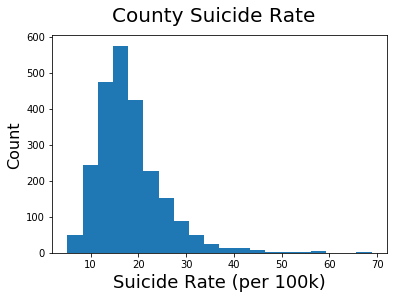

In [61]:
n_bins = 20
fig = plt.figure()
plt.hist(df_clean['Suicide Rate'], bins=n_bins)
fig.suptitle('County Suicide Rate', fontsize=20)
plt.xlabel('Suicide Rate (per 100k)', fontsize=18)
plt.ylabel('Count', fontsize=16)
print(f'Minimum suicide rate: {df_clean["Suicide Rate"].values.min()}')
print(f'Maximum suicide rate: {df_clean["Suicide Rate"].values.max()}')

In [65]:
# Plot map of suicide rate across USA
import plotly.figure_factory as ff

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
              "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
              "#08519c", "#0b4083", "#08306b"]

endpts = list(np.linspace(0, 35, len(colorscale) - 1))
fips = df_grim.index.values.tolist()
values = df_grim['Suicide Rate'].tolist()

In [74]:
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=True,
    show_hover=True,
    asp = 2.9,
    title_text = 'USA by Suicide Rate',
    legend_title = 'Suicides per 100k'
)
fig.layout.template = None
fig.show()

Slope = -0.00013539722644464268
r-squared = 0.06846093713475393
p-value = 3.770842722442979e-38


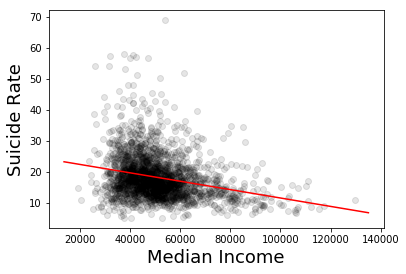

In [16]:
# Plot single variable (Median Income) against suicide rate

# Define x and y
x = df_clean['Median Income']
y = df_clean['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('Median Income', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = 10.320971793027677
r-squared = 0.259572301107903
p-value = 1.047432562061268e-155


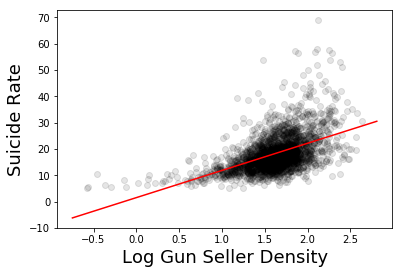

In [17]:
# Plot single variable (Median Income) against suicide rate

# Define x and y
x = df_clean['Log Gun Seller Density']
y = df_clean['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('Log Gun Seller Density', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Median Income
Slope = -0.00013539722644464268
r-squared = 0.06846093713475393
p-value = 3.770842722442979e-38


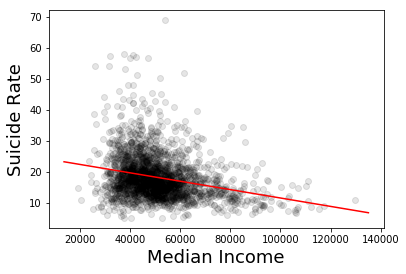

Log Population Density
Slope = -6.082047335181863
r-squared = 0.3289440221091242
p-value = 5.315303706146644e-206


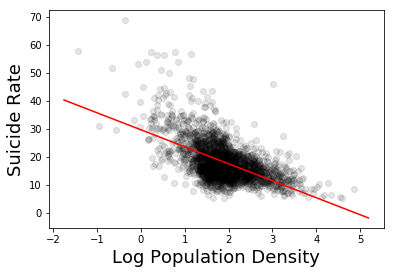

HS Drop Out Rate
Slope = 33.167756524135385
r-squared = 0.08325147193460268
p-value = 2.2920874200757206e-46


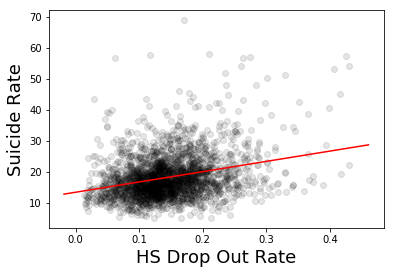

Veteran Rate
Slope = 48.93013918576048
r-squared = 0.11363828733663896
p-value = 1.1953840847574209e-63


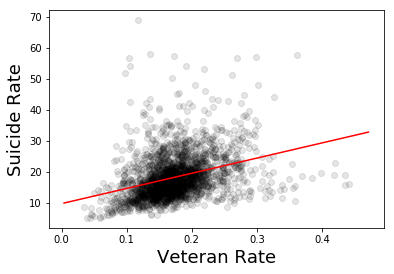

Disability Rate
Slope = 36.39143359251561
r-squared = 0.09677564027931362
p-value = 5.460870714389651e-54


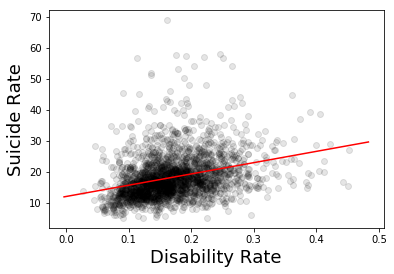

Housing Renter Rate
Slope = -18.6530995876118
r-squared = 0.04594867948157124
p-value = 7.205293371685185e-26


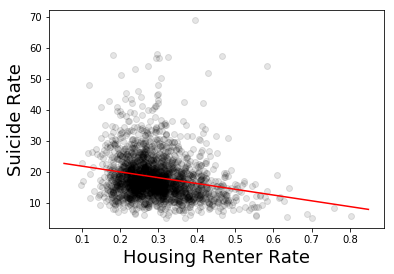

Living Alone Rate
Slope = 42.365859419152365
r-squared = 0.02799134580953542
p-value = 3.065858389197479e-16


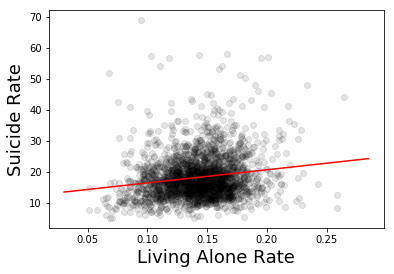

Professional Rate
Slope = -48.70463695534236
r-squared = 0.09923898064234726
p-value = 2.1729303100305858e-55


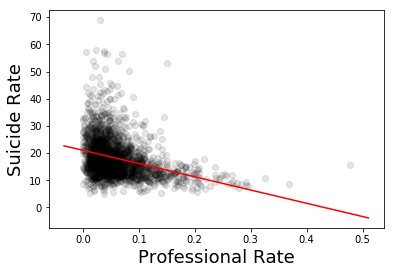

Native American Rate
Slope = 34.09498061637351
r-squared = 0.10899133746342038
p-value = 5.716487516865081e-61


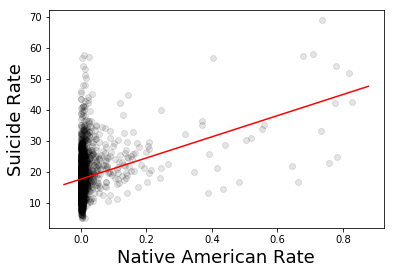

Poverty Rate
Slope = 12.674599139000296
r-squared = 0.011617055286819429
p-value = 1.5893886575470821e-07


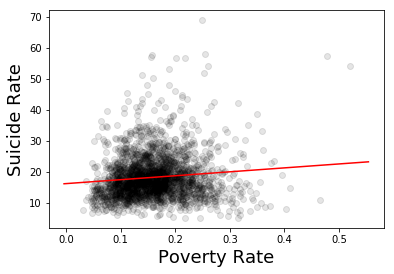

Log Gun Seller Density
Slope = 10.320971793027677
r-squared = 0.259572301107903
p-value = 1.047432562061268e-155


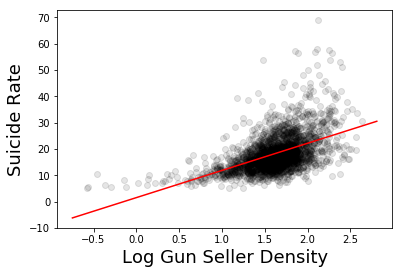

In [18]:
# Plot all variables against suicide rate

# List of all variables that will be in the multiple regression model

# vars_model = ['Median Income', 'Log Population Density', 'HS Drop Out Rate', 'Unemployment Rate', 'Uninsured Rate', 'Poverty Rate', \
#              'Veteran Rate', 'Disability Rate', 'Housing Renter Rate', 'Living Alone Rate', 'Professional Rate', 'Native American Rate', \
#               'Daylight', 'People per Mental Health Provider', 'Log Gun Seller Density']

vars_model = ['Median Income', 'Log Population Density', 'HS Drop Out Rate', 'Veteran Rate', 'Disability Rate', \
              'Housing Renter Rate', 'Living Alone Rate', 'Professional Rate', 'Native American Rate', 'Poverty Rate', \
              'Log Gun Seller Density']

# Plot all graphs
plt.figure()
for thisVar in vars_model:
    # Define x and y
    x = df_clean[thisVar]
    y = df_clean['Suicide Rate']
    # Plot data points
    plt.scatter(x, y, c='black', alpha=0.1)
    plt.ylabel('Suicide Rate', fontsize=18)
    plt.xlabel(thisVar, fontsize=18)
    # Linear Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # Plot a line from slope and intercept
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color="red")
    print(thisVar)
    print(f"Slope = {slope}")
    print(f"r-squared = {r_value**2}")
    print(f"p-value = {p_value}")
    plt.show()


In [19]:
# Define variables for multiple regression model
X = df_clean[[*vars_model]]
y = df_clean['Suicide Rate'].values.reshape(-1, 1)
# print(X.shape, y.shape)
# Split data into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42) # 70% data for train, 30% for test
print(f'Train data: {len(y_train)} data points')
print(f'Test data: {len(y_test)} data points')


# Scale the data so the mean is 0 and the standard deviation is 1
# This will allow us to directly compare beta coefficients in the full model
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Train data: 1647 data points
Test data: 707 data points


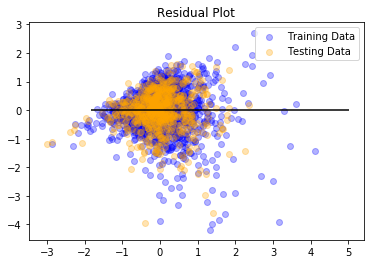

In [20]:
# Fit model and plot the residuals
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data", alpha=0.3)
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data", alpha=0.3)
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [21]:
# Evaluate multiple regression model using test data set
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.47828709048652446, R2: 0.43343704719577103


In [22]:
# Create dataframe with multiple regression beta coefficients and p-values
data = {'Variable': vars_model, 'Beta Coefficient': model.coef_.tolist()[0], 'p-value': model.p.tolist()[0]}
df_lm = pd.DataFrame(data)
alpha = 1-(1-0.05)**(1/len(vars_model)) # corrected for multiple comparisons (Sidak)
df_lm['Significant_high'] = df_lm['p-value'] < alpha
df_lm['Significant_low'] = df_lm['p-value'] < 0.05

df_lm = df_lm.sort_values('Beta Coefficient', ascending =False)
df_lm

Variable  Beta Coefficient       p-value  Significant_high  \
8     Native American Rate          0.253438  0.000000e+00              True   
10  Log Gun Seller Density          0.166017  1.835100e-08              True   
3             Veteran Rate          0.165932  9.547918e-15              True   
4          Disability Rate          0.149796  1.377468e-07              True   
2         HS Drop Out Rate          0.114553  8.354633e-08              True   
6        Living Alone Rate          0.114148  9.057398e-07              True   
7        Professional Rate          0.050749  7.775514e-02             False   
0            Median Income          0.048522  2.982502e-01             False   
5      Housing Renter Rate         -0.000783  9.755648e-01             False   
9             Poverty Rate         -0.068409  1.075672e-01             False   
1   Log Population Density         -0.294755  0.000000e+00              True   

    Significant_low  
8              True  
10             True  
3              True  
4              True  
2              True  
6              True  
7             False  
0             False  
5             False  
9             False  
1              True

In [23]:
print(f'# Variables in Model: {len(vars_model)}')

# Variables in Model: 11


In [24]:
# Create a neural network with multiple layers

# add r squared as a metric for model
def det_coeff(y_true, y_pred):
    u = K.sum(K.square(y_true - y_pred))
    v = K.sum(K.square(y_true - K.mean(y_true)))
    return K.ones_like(v) - (u / v)

# define model architecture
def build_model():
    model = Sequential()
    model.add(Dense(units=11, activation='sigmoid', input_dim=len(vars_model))) # try sigmoid vs. relu
    model.add(Dense(units=7, activation='sigmoid'))
    model.add(Dense(1))
    
    optimizer = tensorflow.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', det_coeff])
    
    return model

In [25]:
# build model and print summary
model = build_model()
model.summary()

# example_batch = X_train_scaled[:10]
# example_result = deep_model.predict(example_batch)
# example_result

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [26]:
from tensorflow import keras
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train_scaled, y_train_scaled, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(np.mean(hist['val_det_coeff'].values[-5:None]))
hist.tail()

0.3926034212112427


loss  mean_absolute_error  mean_squared_error  det_coeff  val_loss  \
279  0.431932             0.478376            0.431932   0.507054  0.489089   
280  0.431604             0.477040            0.431604   0.469031  0.493771   
281  0.431345             0.478774            0.431345   0.477189  0.489520   
282  0.430984             0.476990            0.430984   0.502211  0.496538   
283  0.431036             0.479097            0.431036   0.468372  0.493449   

     val_mean_absolute_error  val_mean_squared_error  val_det_coeff  epoch  
279                 0.502528                0.489089       0.328909    279  
280                 0.508523                0.493771       0.405305    280  
281                 0.503153                0.489520       0.478561    281  
282                 0.511396                0.496538       0.345842    282  
283                 0.508376                0.493450       0.404401    283

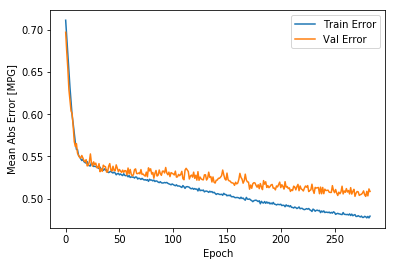

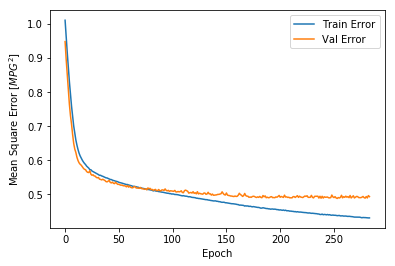

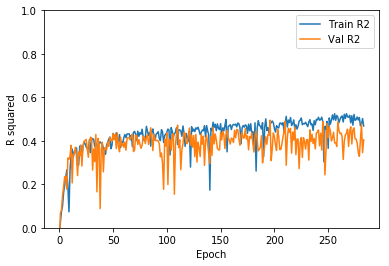

In [28]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('R squared')
  plt.plot(hist['epoch'], hist['det_coeff'],
           label='Train R2')
  plt.plot(hist['epoch'], hist['val_det_coeff'],
           label = 'Val R2')
  plt.ylim([0,1])
  plt.legend()

  plt.show()


plot_history(history)


In [29]:
# loss, mae, mse, r2 = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)

In [ ]:
# Compile the model
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
# Fit the model to the training data
deep_model.fit(X_train_scaled, y_train_categorical, epochs=100, shuffle=True, verbose=2)

In [ ]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")